In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
1


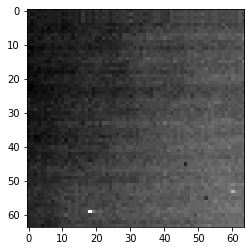

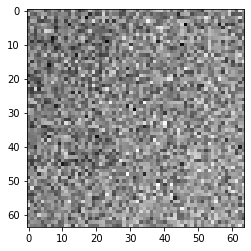

2


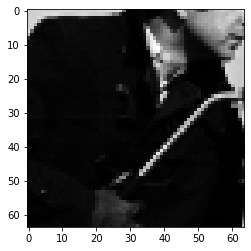

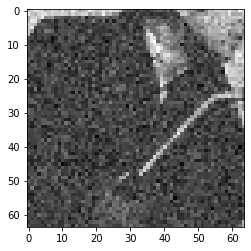

3


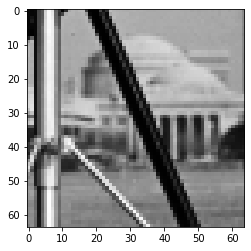

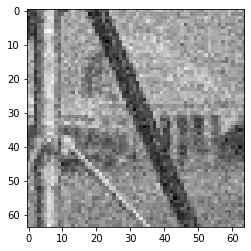

4


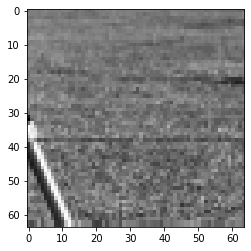

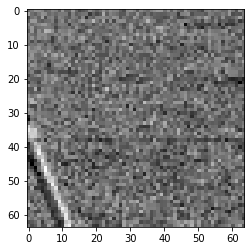

5


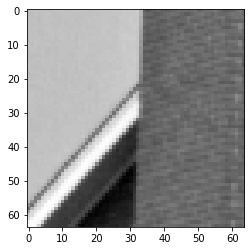

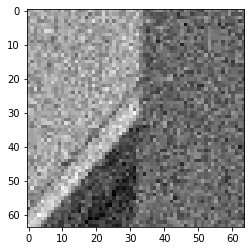

6


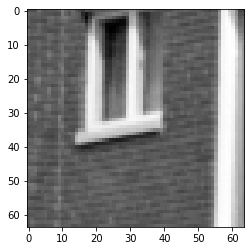

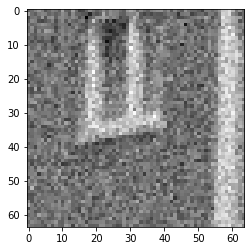

7


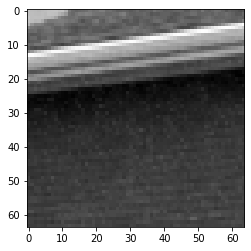

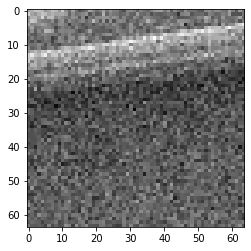

(343, 64, 64)
(343, 64, 64)


In [13]:
import numpy as np

from skimage.util.shape import view_as_windows

from PIL import Image

from matplotlib import pyplot as plt

train = []

for i in range(1,8):
  file = "/content/drive/MyDrive/SMAI/Project/"+str(i)+".png"
  image = Image.open(file)
  image = np.asarray(image)
  t = view_as_windows(image, (64,64), step=32).reshape((-1,64,64))
  train.append(t)
  print(image.shape)

train =  np.array(train).reshape((-1,64,64))

mean = 0
var = 625
sigma = 25

gauss = np.random.normal(mean,sigma,(64,64))

traing = train + gauss


for i in range(7):
  print(i+1)
  plt.imshow(train[i*16],cmap='gray')
  plt.show()
  plt.imshow(traing[i*16],cmap='gray')
  plt.show()

print(train.shape)
print(traing.shape)


In [7]:
import tensorflow as tf

In [8]:
class FeatureExtraction(tf.keras.Model):
  def __init__(self):
    super(FeatureExtraction,self).__init__()
    self.conv_block_up=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, activation="relu")
    self.dilated_conv_block_up=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, dilation_rate=2,activation="relu")

    self.conv_block_down=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, activation="relu")
    self.dilated_conv_block_down=tf.keras.layers.Conv2D(8,(3,3), padding="same", strides=1, dilation_rate=2,activation="relu")

  def call(self,input_tensor):
    x=self.conv_block_up(input_tensor)
    y=self.dilated_conv_block_up(x)
    z=self.dilated_conv_block_down(input_tensor)
    a=self.conv_block_down(z)

    return tf.keras.layers.Add()([x,y,z,a])

In [9]:
class FeatureIntegration(tf.keras.Model):
  def __init__(self):
    super(FeatureIntegration,self).__init__()
    self.conv_block_first=tf.keras.layers.Conv2D(1,(1,1), strides=1,padding="same", activation="relu")
    self.conv_block_up=tf.keras.layers.Conv2D(8,(3,3), strides=1,padding="same", activation="relu")
    self.dilated_conv_block_up=tf.keras.layers.Conv2D(8,(3,3),dilation_rate=2,padding="same",activation="relu")
    self.conv_block_down=tf.keras.layers.Conv2D(8,(3,3), strides=1,padding="same", activation="relu")
    self.dilated_conv_block_down=tf.keras.layers.Conv2D(8,(3,3),dilation_rate=2,padding="same",activation="relu")
    self.conv_block_second=tf.keras.layers.Conv2D(1,(1,1), strides=1,padding="same", activation="relu")
  def call(self,input_tensor):
    b=self.conv_block_first(input_tensor)
    x=self.conv_block_up(b)
    y=self.dilated_conv_block_up(x)
    z=self.dilated_conv_block_down(b)
    a=self.conv_block_down(z)
    add_first=tf.keras.layers.Add()([x,y,z,a])
    f=self.conv_block_second(add_first)
    return tf.keras.layers.Add()([f,input_tensor])

In [10]:
class Reconstruction(tf.keras.Model):
  def __init__(self):
    super(Reconstruction,self).__init__()
    self.conv_block_first=tf.keras.layers.Conv2D(1,(1,1), strides=1,padding="same", activation="sigmoid")
  def call(self,input_tensor):
    b=self.conv_block_first(input_tensor)
    return b

In [14]:
temp = np.expand_dims(traing, axis=-1)

temp = temp/255.0

print(temp.shape)

temp2 = np.expand_dims(train, axis=-1)

temp2 = temp2/255.0

print(temp2.shape)


from keras.models import Sequential

model = Sequential()

model.add(FeatureExtraction())

model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())
model.add(FeatureIntegration())

model.add(Reconstruction())

model.compile(loss='mse')

results = model.fit(temp, temp2, epochs=10, verbose=1)

model.summary()


(343, 64, 64, 1)
(343, 64, 64, 1)
Epoch 1/10
11/11 [==============================] - 7s 65ms/step - loss: 0.0703
Epoch 2/10
11/11 [==============================] - 1s 58ms/step - loss: 0.0411
Epoch 3/10
11/11 [==============================] - 1s 59ms/step - loss: 0.0185
Epoch 4/10
11/11 [==============================] - 1s 59ms/step - loss: 0.0141
Epoch 5/10
11/11 [==============================] - 1s 59ms/step - loss: 0.0122
Epoch 6/10
11/11 [==============================] - 1s 59ms/step - loss: 0.0107
Epoch 7/10
11/11 [==============================] - 1s 59ms/step - loss: 0.0103
Epoch 8/10
11/11 [==============================] - 1s 59ms/step - loss: 0.0095
Epoch 9/10
11/11 [==============================] - 1s 59ms/step - loss: 0.0093
Epoch 10/10
11/11 [==============================] - 1s 58ms/step - loss: 0.0088
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_ex

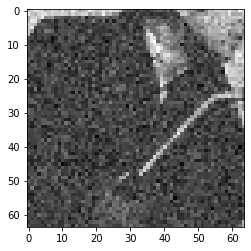

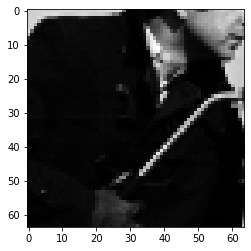

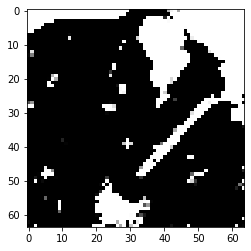

In [18]:
plt.imshow(traing[16],cmap='gray')
plt.show()

plt.imshow(train[16],cmap='gray')
plt.show()

temp = np.expand_dims(traing[16],axis=(0,-1))

pred = model(temp)

pred = np.squeeze(pred,(0,-1))

plt.imshow(pred,cmap='gray')
plt.show()